# Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt

# Load ECG data

In [2]:
# Download the dataset

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

Normalize the data to [0, 1].

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_labels)
                        
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Train the autoencoder using the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms form the abnormal rhytms. 

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [6]:
normal_train_data.shape, normal_test_data.shape

(TensorShape([2359, 140]), TensorShape([560, 140]))

Plot a normal ecg

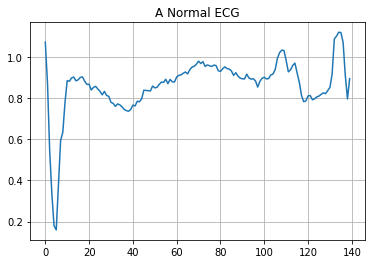

In [7]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot a normal ecg

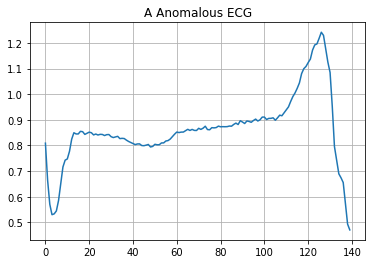

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("A Anomalous ECG")
plt.show()

# Build the model

In [9]:
class AnomalyDetector(tf.keras.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
 
    self.encoder = tf.keras.Sequential([
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(16, activation='relu'),
                    tf.keras.layers.Dense(8, activation='relu')
                    ])
    
    self.decoder = tf.keras.Sequential([
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(140, activation='sigmoid')
                ])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 106ms/step - loss: 0.3701 - val_loss: 0.3649
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 0.3602 - val_loss: 0.3490
Epoch 3/20
5/5 [==============================] - 0s 31ms/step - loss: 0.3377 - val_loss: 0.3181
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 0.2990 - val_loss: 0.2729
Epoch 5/20
5/5 [==============================] - 0s 28ms/step - loss: 0.2461 - val_loss: 0.2182
Epoch 6/20
5/5 [==============================] - 0s 24ms/step - loss: 0.1940 - val_loss: 0.1784
Epoch 7/20
5/5 [==============================] - 0s 20ms/step - loss: 0.1636 - val_loss: 0.1517
Epoch 8/20
5/5 [==============================] - 0s 21ms/step - loss: 0.1373 - val_loss: 0.1242
Epoch 9/20
5/5 [==============================] - 0s 15ms/step - loss: 0.1083 - val_loss: 0.1038
Epoch 10/20
5/5 [==============================] - 0s 35ms/step - loss: 0.0875 - val_loss: 0.0900
Epoch 11/20
5/5 [===========

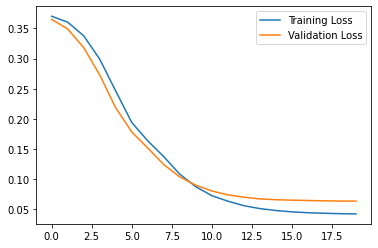

In [12]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is grater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

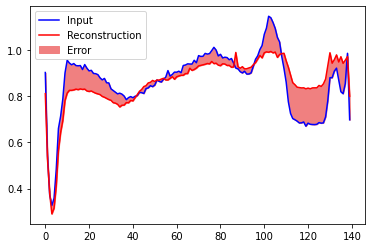

In [13]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [21]:
decoded_imgs.shape

(560, 140)

# Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set.

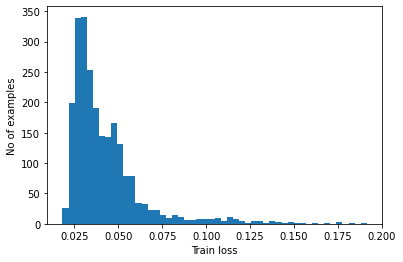

In [14]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviation above the mean.

In [15]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.063715994


Note: there are other strategies you could use to select a threshold avobe which test examples should be classified as anomalous, the correct approach will depend on your dataset.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing th ethreshold, you can adjust the precision and recall of your classifier.

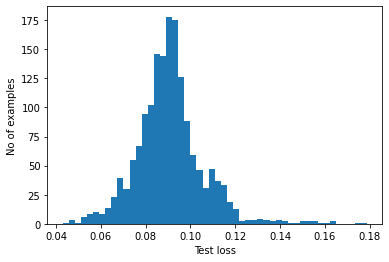

In [16]:
reconstructions = autoencoder.predict(anomalous_train_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_train_data)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [17]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuarcy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [18]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuarcy = 0.944
Precision = 0.9864864864864865
Recall = 0.9125


In [19]:
test_data.shape, preds.shape

(TensorShape([1000, 140]), TensorShape([1000]))

In [20]:
preds[0]

<tf.Tensor: shape=(), dtype=bool, numpy=False>